# LGN Unit Analysis

Looking at how many LGN units are needed in the model.

January 17, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import seaborn as sns
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(cell_type_list=['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3'], down_sample=2, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 51.26786947250366 sec


In [3]:
# Load baseline LL
GLM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.pkl', allow_pickle=True)
GQM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.pkl', allow_pickle=True)

In [4]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))
mu0s = data.mu0s

In [5]:
L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 1491
Number of time points 510000


## Degree to Qmu

In [7]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [8]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(V1_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (1491,)


## Create Model

In [9]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

In [10]:
XTreg = 0.0001
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.05 # d2/dx
Creg1 = 0.001 # center

MaxReg = 0.001

angle_mode = 'nearest' # 'bilinear'

NQ = len(angles)

num_LGN_units = [1,2,3,4]
num_repeat = 20
models = {}
fws = [19, 19, 5, 5]

for i in range(len(num_LGN_units)):
    num_subs = [num_LGN_units[i], 24, 16, 16]  

    # LGN LAYER
    clayersQ = [STconvLayer.layer_dict( 
        input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
        filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
        padding='circular', output_norm='batch', window='hamming', initialize_center=True,
        reg_vals={'d2xt':XTreg, 'd2x':Xreg0, 'center': Creg0} )]

    # PROJECTION LAYER
    clayersQ.append(
        OriConvLayer.layer_dict(
            num_filters=num_subs[1], num_inh=num_subs[1]//2,
            filter_width=fws[1], NLtype='relu', norm_type=1,
            bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center=True, 
            reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

    # TIME SHIFT LAYER
    clayersQ.append(TimeShiftLayer.layer_dict())

    # REST
    for ii in range(2,len(fws)):
        clayersQ.append(OriConvLayer.layer_dict( 
            num_filters=num_subs[ii], num_inh=num_subs[ii]//2, bias=False, norm_type=1, 
            filter_width=fws[ii], NLtype='relu',
            output_norm='batch', initialize_center=True, #window='hamming', 
            angles=angles) )
        
    scaffold_netQ =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

    readout_parsQ = ReadoutLayerQsample.layer_dict(
        num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
        reg_vals={'max': MaxReg})

    readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

    for k in range(num_repeat):
        models[str(num_LGN_units[i])+' LGN Units '+str(k)] = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson', seed=100+k)
        print('Model', i, k, 'created')

Model 0 0 created
Model 0 1 created
Model 0 2 created
Model 0 3 created
Model 0 4 created
Model 0 5 created
Model 0 6 created
Model 0 7 created
Model 0 8 created
Model 0 9 created
Model 0 10 created
Model 0 11 created
Model 0 12 created
Model 0 13 created
Model 0 14 created
Model 0 15 created
Model 0 16 created
Model 0 17 created
Model 0 18 created
Model 0 19 created
Model 1 0 created
Model 1 1 created
Model 1 2 created
Model 1 3 created
Model 1 4 created
Model 1 5 created
Model 1 6 created
Model 1 7 created
Model 1 8 created
Model 1 9 created
Model 1 10 created
Model 1 11 created
Model 1 12 created
Model 1 13 created
Model 1 14 created
Model 1 15 created
Model 1 16 created
Model 1 17 created
Model 1 18 created
Model 1 19 created
Model 2 0 created
Model 2 1 created
Model 2 2 created
Model 2 3 created
Model 2 4 created
Model 2 5 created
Model 2 6 created
Model 2 7 created
Model 2 8 created
Model 2 9 created
Model 2 10 created
Model 2 11 created
Model 2 12 created
Model 2 13 created
Mode

In [ ]:
LL_dict = {}
for i in range(len(num_LGN_units)):
    for k in range(num_repeat):
        cnn = models[str(num_LGN_units[i])+' LGN Units '+str(k)]
        cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
        cnn.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
        cnn.networks[1].layers[0].fit_mus(True)
        cnn.networks[1].layers[0].fit_Qmus(False)
        cnn.networks[1].layers[0].Qsample_mode = angle_mode
        cnn.block_sample = True

        start = time.time()
        cnn.fit(data, **adam_pars, verbose=False)
        end = time.time()

        cnn.save_model('models/LGN_testing_model_'+str(num_LGN_units[i])+'_units_'+str(k)+'.ndn')

        LL_dict[str(num_LGN_units[i])+' LGN Units '+str(k)] = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)

        print('Model', i, k, 'done fitting')

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus


In [13]:
LL_dict.keys()

dict_keys(['1 LGN Units', '2 LGN Units', '3 LGN Units', '4 LGN Units'])

## Compare Log-Likelihood

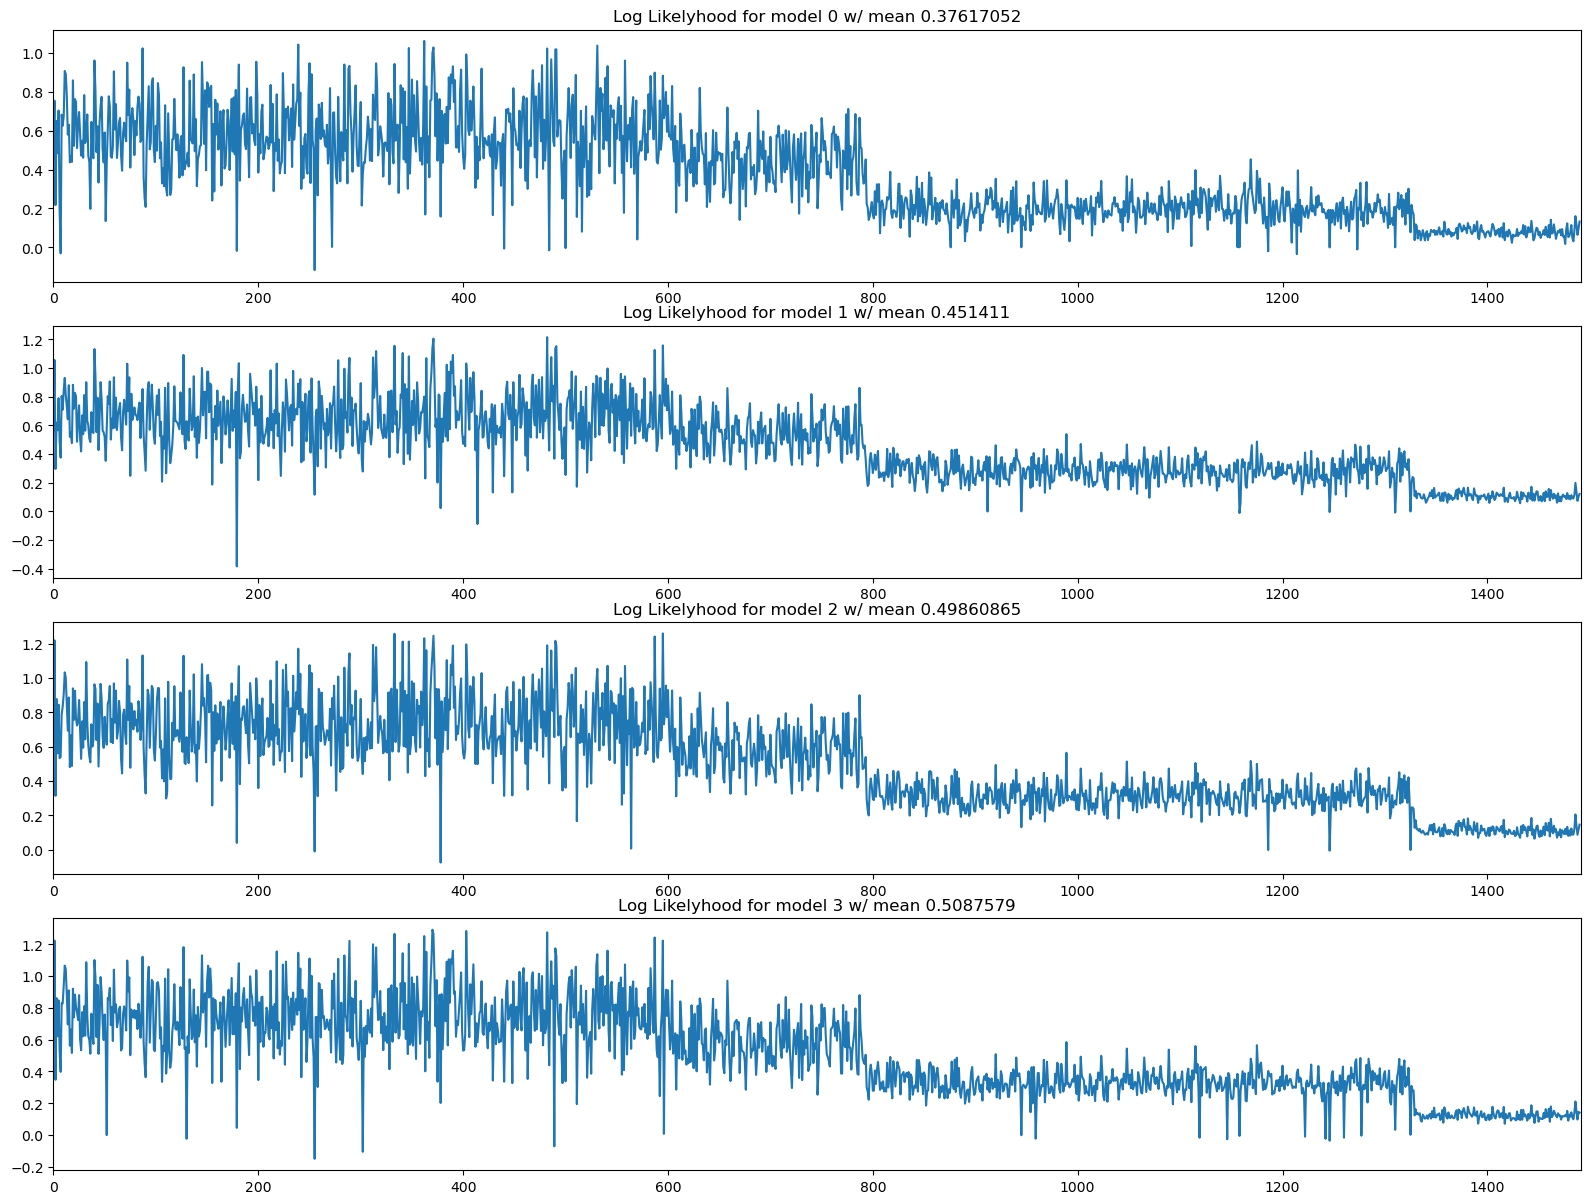

In [16]:
ss(4,1)
for i in range(len(num_LGN_units)):
    plt.subplot(4,1,i+1)
    plt.plot(LL_dict[str(num_LGN_units[i])+' LGN Units'])
    plt.title('Log Likelyhood for model '+str(i)+' w/ mean '+str(np.mean(LL_dict[str(num_LGN_units[i])+' LGN Units'])))
    plt.xlim([0,NC])
plt.show()

Text(0, 0.5, 'Log-Likelihood')

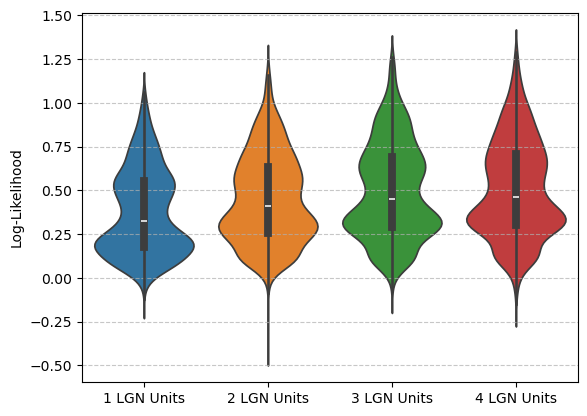

In [36]:
LL_to_plot = [] 
for i in range(len(num_LGN_units)):
    LL_to_plot.append(list(LL_dict[str(num_LGN_units[i])+' LGN Units']))
labels = list(LL_dict.keys())
sns.violinplot(data=LL_to_plot)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Log-Likelihood')

Text(0.5, 1.0, 'Layer 2/3 Inh')

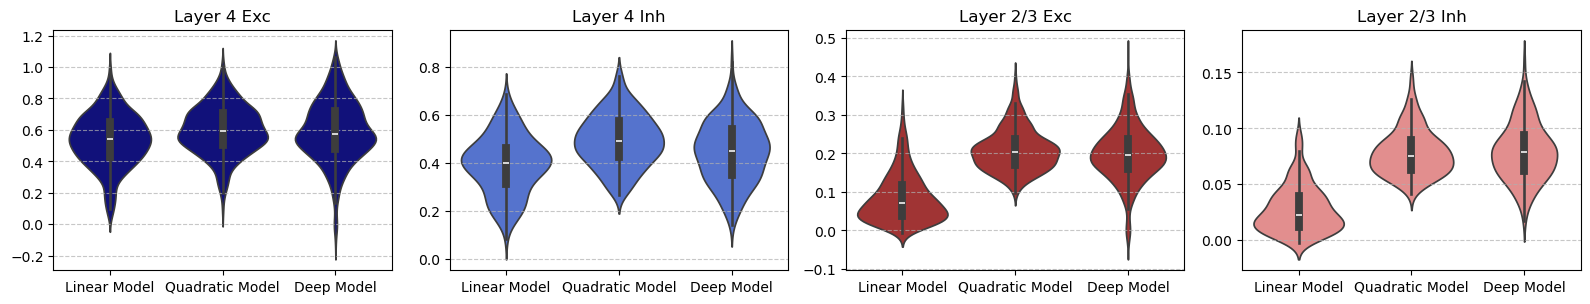

In [38]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[0])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

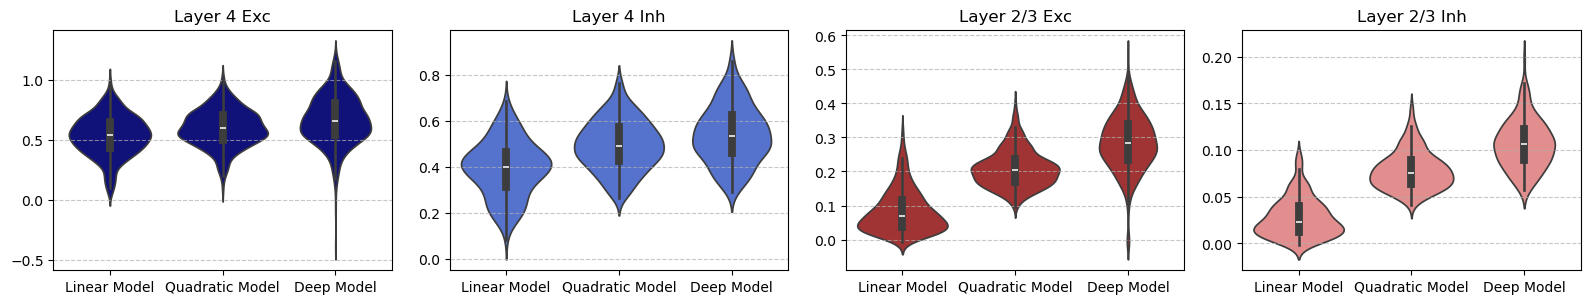

In [39]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[1])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

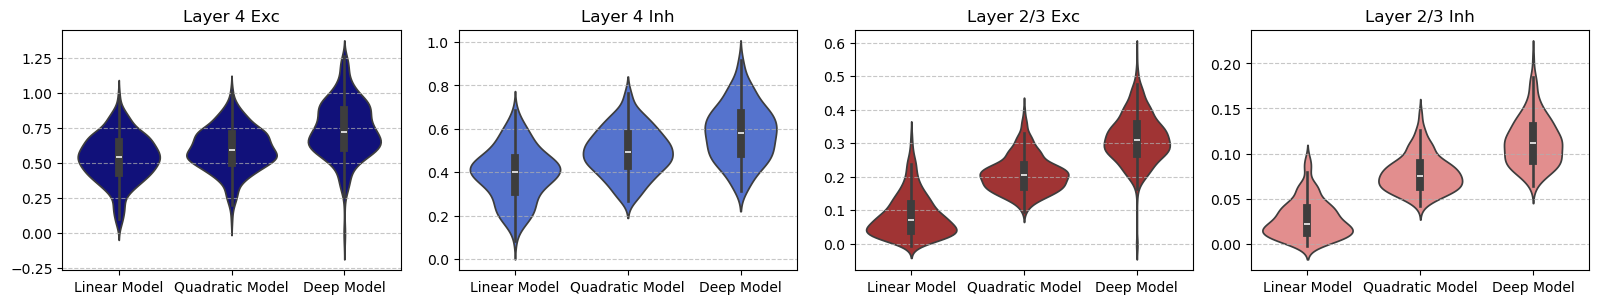

In [40]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[2])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

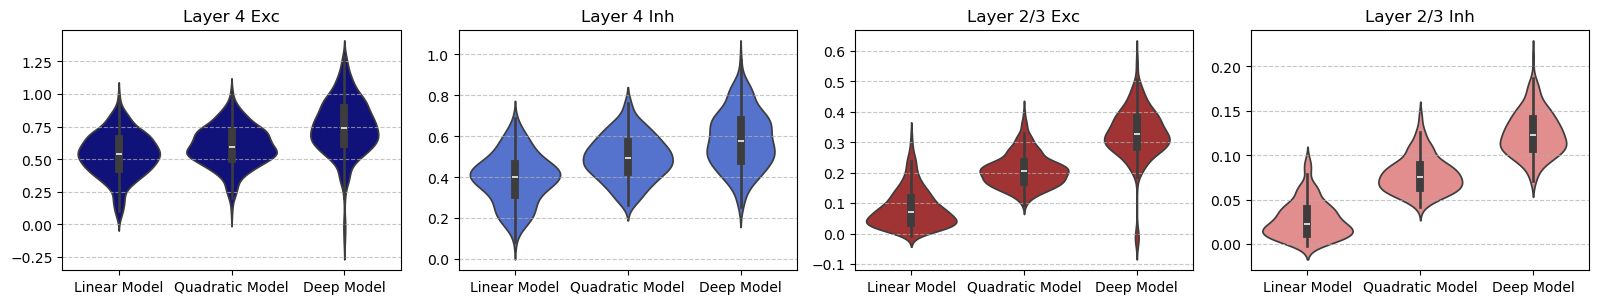

In [41]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[3])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

## Compare Filters

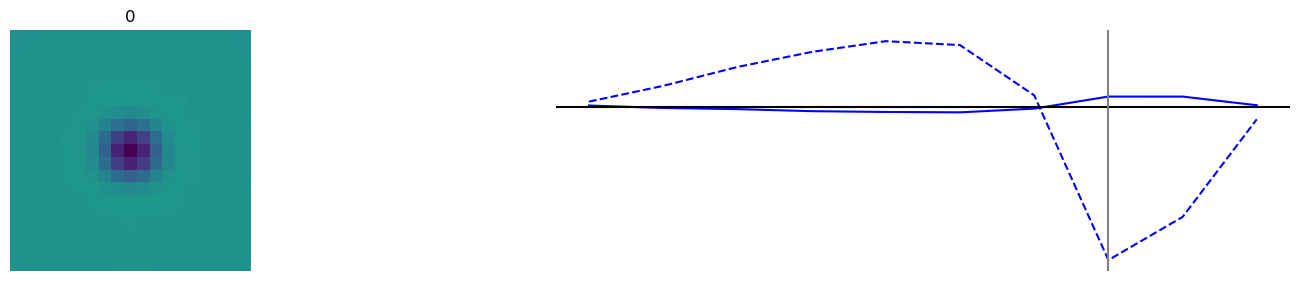

In [31]:
models[str(num_LGN_units[0])+' LGN Units'].plot_filters()

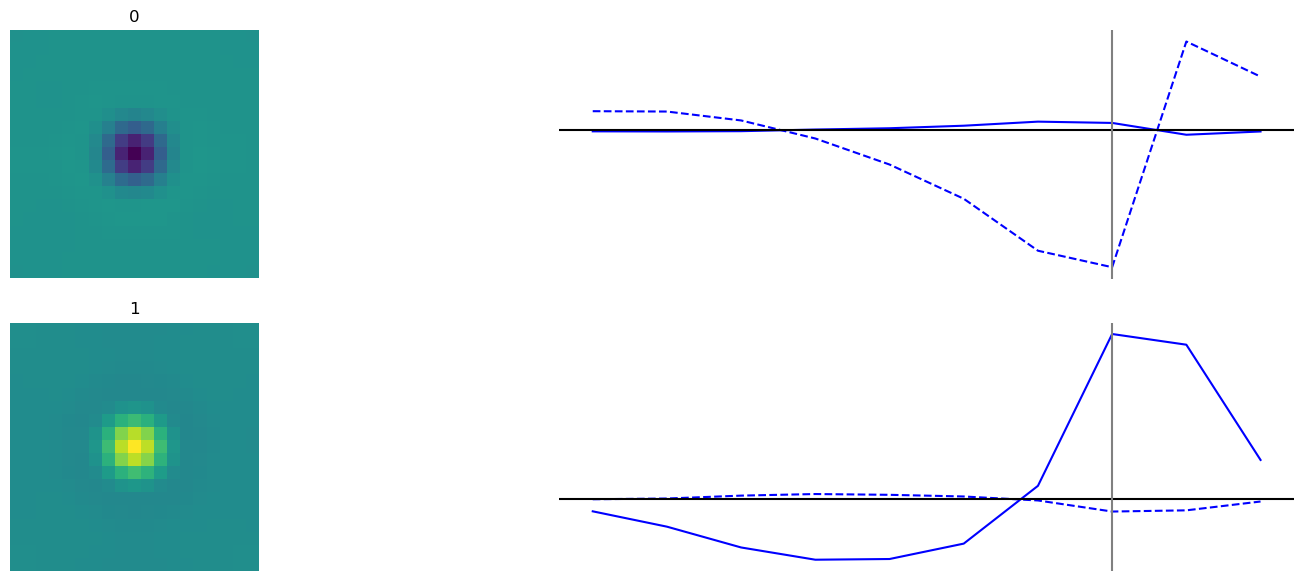

In [32]:
models[str(num_LGN_units[1])+' LGN Units'].plot_filters()

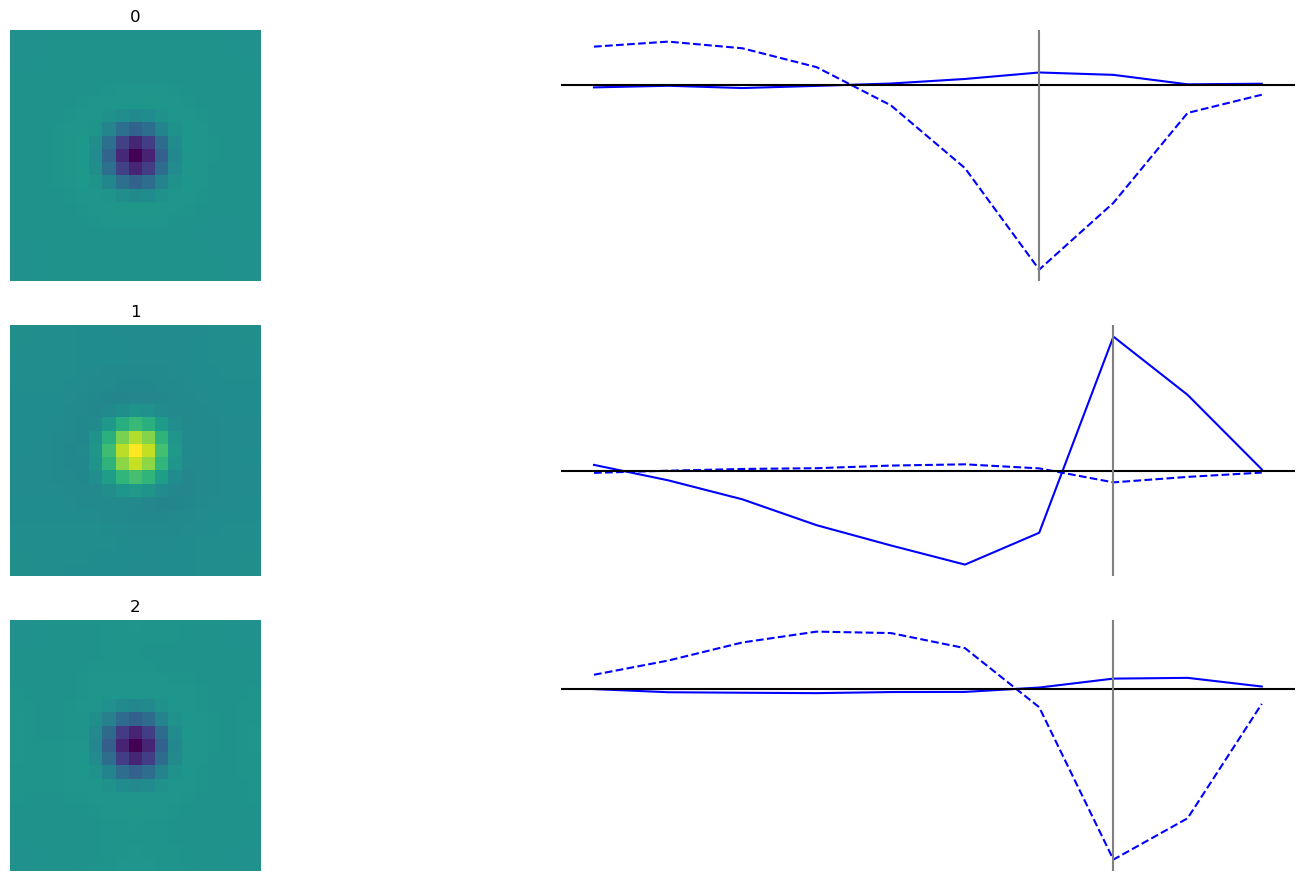

In [34]:
models[str(num_LGN_units[2])+' LGN Units'].plot_filters()

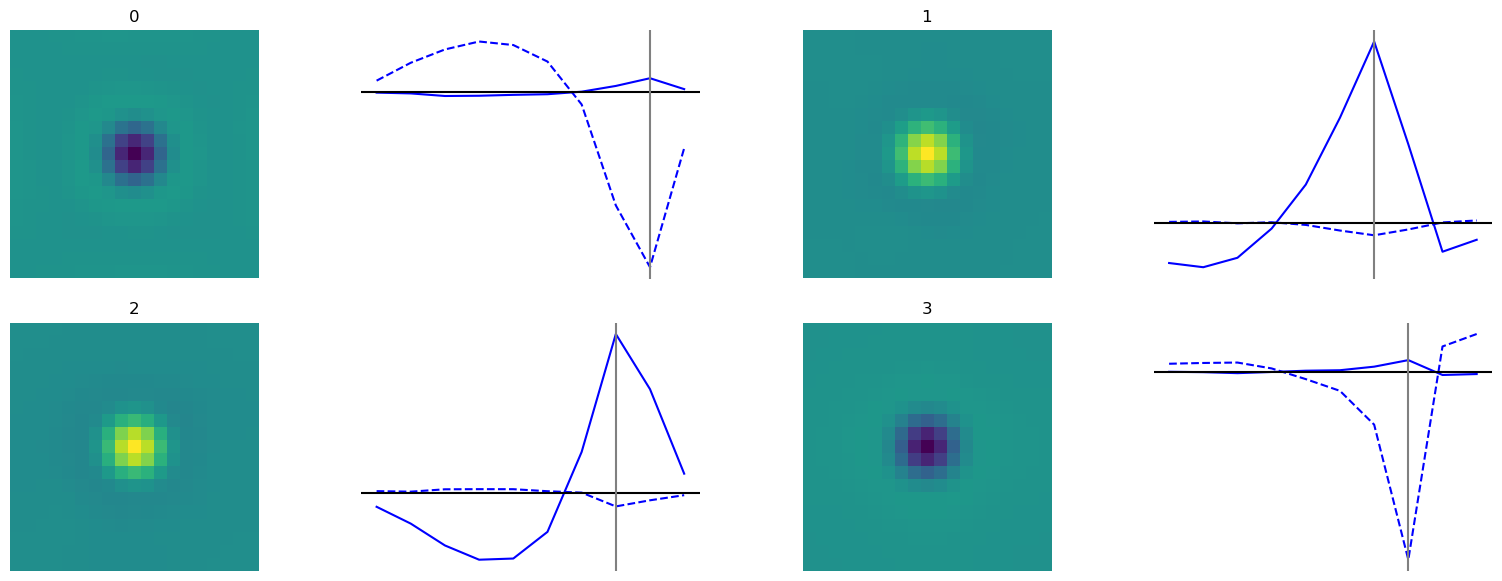

In [35]:
models[str(num_LGN_units[3])+' LGN Units'].plot_filters()

## Redundancy?

In [43]:
model3 = deepcopy(models[str(num_LGN_units[2])+' LGN Units'])
print('Stim in shape:',data[0]['stim'].shape)
LGN_level_output = model3.networks[0].layers[0](data[0]['stim'])
print('LGN Level out shape:',LGN_level_output.shape)

Stim in shape: torch.Size([1000, 3600])
LGN Level out shape: torch.Size([1000, 10800])


In [44]:
model3.networks[0].layers[0].output_dims

[3, 60, 60, 1]

In [45]:
# Z-score across time dim
LGN_output_zscore = (LGN_level_output-torch.mean(LGN_level_output,axis=0))/torch.std(LGN_level_output,axis=0)
LGN_output_zscore.shape

torch.Size([1000, 10800])

In [46]:
# Reshape to output dims
LGN_output_zscore = LGN_output_zscore.reshape([data[0]['stim'].shape[0]]+model3.networks[0].layers[0].output_dims[:3]).detach().numpy()
LGN_output_zscore.shape

(1000, 3, 60, 60)

In [48]:
T = LGN_output_zscore.shape[0]
N = model3.networks[0].layers[0].output_dims[0] # num units
D = np.prod(model3.networks[0].layers[0].output_dims[1:])
output_corr = np.zeros((N,N))
for i in range(N):
    x_1 = LGN_output_zscore[:,i,L//2-1,L//2-1]
    for j in range(N):
        x_2 = LGN_output_zscore[:,j,:,:].reshape((T,D))
        output_corr[i,j] = np.max((x_2.T@x_1)/T)
print(output_corr.shape)

(3, 3)


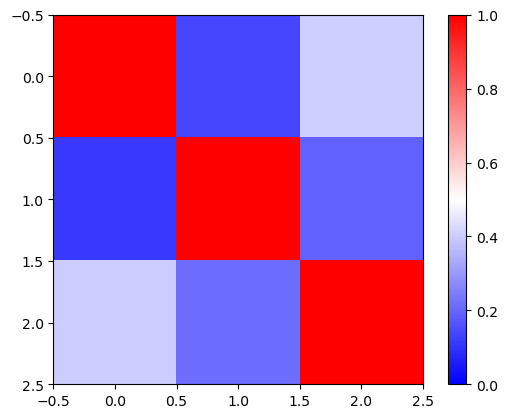

In [52]:
imagesc(output_corr, cmap='bwr')
plt.clim([0,1])
plt.colorbar()

In [61]:
model4 = deepcopy(models[str(num_LGN_units[3])+' LGN Units'])
print('Stim in shape:',data[0]['stim'].shape)
LGN_level_output = model4.networks[0].layers[0](data[0]['stim']).detach().numpy()
print('LGN Level out shape:',LGN_level_output.shape)

Stim in shape: torch.Size([1000, 3600])
LGN Level out shape: (1000, 14400)


In [62]:
model4.networks[0].layers[0].output_dims

[4, 60, 60, 1]

In [63]:
# Z-score across time dim
LGN_output_zscore = (LGN_level_output-np.mean(LGN_level_output,axis=0))/np.std(LGN_level_output,axis=0)
LGN_output_zscore[np.isnan(LGN_output_zscore)] = 0
LGN_output_zscore.shape

(1000, 14400)

In [64]:
# Reshape to output dims
LGN_output_zscore = LGN_output_zscore.reshape([data[0]['stim'].shape[0]]+model4.networks[0].layers[0].output_dims[:3])
LGN_output_zscore.shape

(1000, 4, 60, 60)

In [65]:
T = LGN_output_zscore.shape[0]
N = model4.networks[0].layers[0].output_dims[0] # num units
D = np.prod(model4.networks[0].layers[0].output_dims[1:])
output_corr = np.zeros((N,N))
for i in range(N):
    x_1 = LGN_output_zscore[:,i,L//2-1,L//2-1]
    for j in range(N):
        x_2 = LGN_output_zscore[:,j,:,:].reshape((T,D))
        output_corr[i,j] = np.max((x_2.T@x_1)/T)
print(output_corr.shape)

(4, 4)


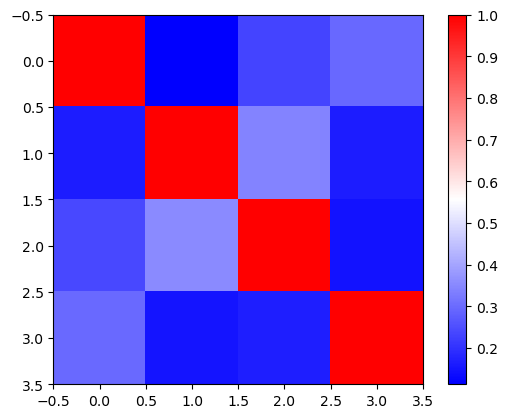

In [66]:
imagesc(output_corr, cmap='bwr')
#plt.clim([0,1])
plt.colorbar()

## Time Profile

In [67]:
model3_filters = model3.get_weights(ffnet_target=0,layer_target=0)
model3_filters.shape

(19, 19, 10, 3)

In [70]:
model3_filter_ts = model3_filters[fws[0]//2-1,fws[0]//2-1,:,:]
model3_filter_ts.shape

(10, 3)

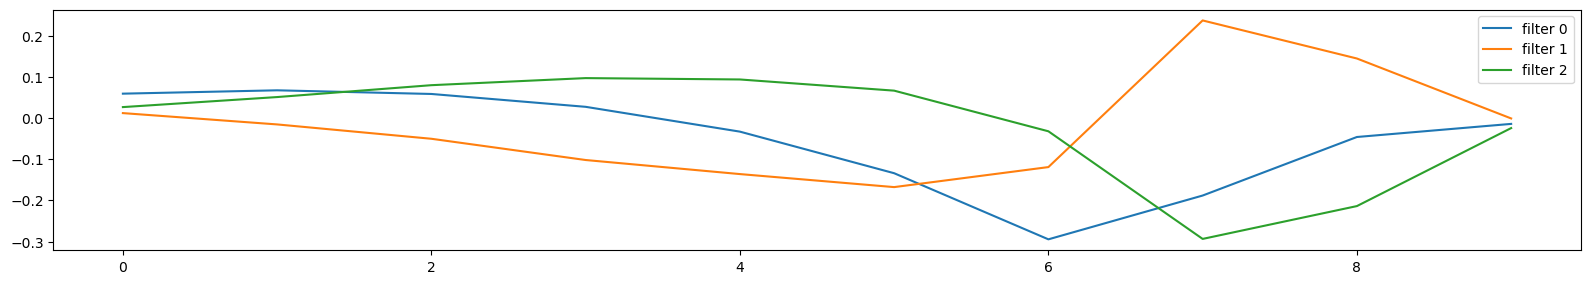

In [76]:
ss()
plt.plot(model3_filter_ts[:,0], label='filter 0')
plt.plot(model3_filter_ts[:,1], label='filter 1')
plt.plot(model3_filter_ts[:,2], label='filter 2')
plt.legend()
plt.show()

In [72]:
model4_filters = model4.get_weights(ffnet_target=0,layer_target=0)
model4_filters.shape

(19, 19, 10, 4)

In [73]:
model4_filter_ts = model4_filters[fws[0]//2-1,fws[0]//2-1,:,:]
model4_filter_ts.shape

(10, 4)

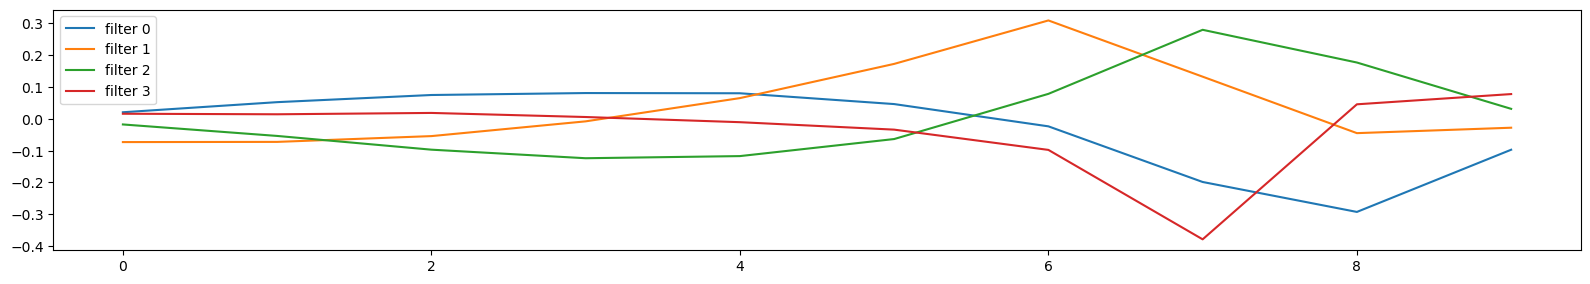

In [75]:
ss()
plt.plot(model4_filter_ts[:,0], label='filter 0')
plt.plot(model4_filter_ts[:,1], label='filter 1')
plt.plot(model4_filter_ts[:,2], label='filter 2')
plt.plot(model4_filter_ts[:,3], label='filter 3')
plt.legend()
plt.show()

## Save LGN models

In [60]:
for i in range(len(num_LGN_units)):
    cnn = models[str(num_LGN_units[i])+' LGN Units']
    cnn.save_model('models/LGN_testing_model_'+str(num_LGN_units[i])+'_units.ndn')

  Model saved:  models/LGN_testing_model_1_units.ndn
  Model saved:  models/LGN_testing_model_2_units.ndn
  Model saved:  models/LGN_testing_model_3_units.ndn
  Model saved:  models/LGN_testing_model_4_units.ndn
